In [4]:
%reset -s -f

In [8]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro

In [9]:
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.1')

pyro.enable_validation(True)
pyro.set_rng_seed(1)
logging.basicConfig(format='%(message)s', level=logging.INFO)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

**Example: Geography and national income**


In [18]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", 
#cont_africa: whether the given nation is in Africa;
           "rugged",
           #rugged: quantifies the Terrain Ruggedness Index;
           "rgdppc_2000"]] 
#rgdppc_2000: Real GDP per capita for the year 2000;
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

In [19]:
# We then convert the Numpy array behind this dataframe to a torch.Tensor for analysis with PyTorch and Pyro.
train = torch.tensor(df.values, dtype=torch.float)
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]

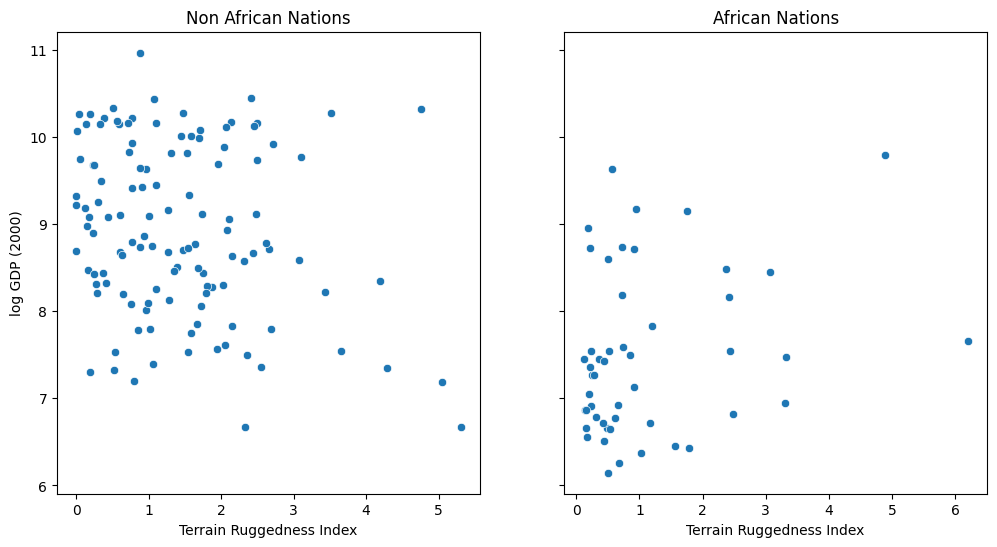

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(x=non_african_nations["rugged"],
                y=non_african_nations["rgdppc_2000"],
                ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(x=african_nations["rugged"],
                y=african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

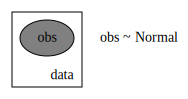

In [28]:
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

def simple_model(is_cont_africa, ruggedness, log_gdp=None):
    a = pyro.param("a", lambda: torch.randn(()))
    b_a = pyro.param("bA", lambda: torch.randn(()))
    b_r = pyro.param("bR", lambda: torch.randn(()))
    b_ar = pyro.param("bAR", lambda: torch.randn(()))
    sigma = pyro.param("sigma", lambda: torch.ones(()), constraint=constraints.positive)

    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

    with pyro.plate("data", len(ruggedness)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

pyro.render_model(simple_model, model_args=(is_cont_africa, ruggedness, log_gdp), render_distributions=True)

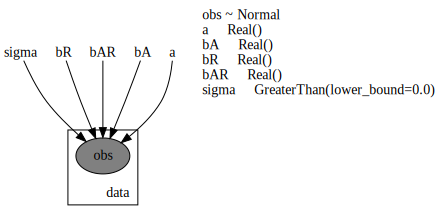

In [29]:
pyro.render_model(simple_model, model_args=(is_cont_africa, ruggedness, log_gdp), render_distributions=True, render_params=True)

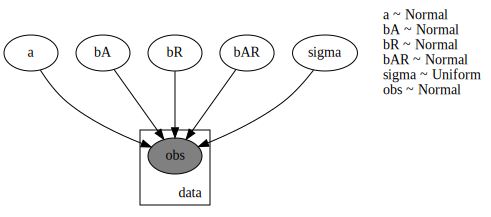

In [30]:
def model(is_cont_africa, ruggedness, log_gdp=None):
    a = pyro.sample("a", dist.Normal(0., 10.))
    b_a = pyro.sample("bA", dist.Normal(0., 1.))
    b_r = pyro.sample("bR", dist.Normal(0., 1.))
    b_ar = pyro.sample("bAR", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))

    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

    with pyro.plate("data", len(ruggedness)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

pyro.render_model(model, model_args=(is_cont_africa, ruggedness, log_gdp), render_distributions=True)


**Example: mean-field variational approximation for Bayesian linear regression in Pyro**

In [31]:
def custom_guide(is_cont_africa, ruggedness, log_gdp=None):
    a_loc = pyro.param('a_loc', lambda: torch.tensor(0.))
    a_scale = pyro.param('a_scale', lambda: torch.tensor(1.),
                         constraint=constraints.positive)
    sigma_loc = pyro.param('sigma_loc', lambda: torch.tensor(1.),
                             constraint=constraints.positive)
    weights_loc = pyro.param('weights_loc', lambda: torch.randn(3))
    weights_scale = pyro.param('weights_scale', lambda: torch.ones(3),
                               constraint=constraints.positive)
    a = pyro.sample("a", dist.Normal(a_loc, a_scale))
    b_a = pyro.sample("bA", dist.Normal(weights_loc[0], weights_scale[0]))
    b_r = pyro.sample("bR", dist.Normal(weights_loc[1], weights_scale[1]))
    b_ar = pyro.sample("bAR", dist.Normal(weights_loc[2], weights_scale[2]))
    sigma = pyro.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))
    return {"a": a, "b_a": b_a, "b_r": b_r, "b_ar": b_ar, "sigma": sigma}


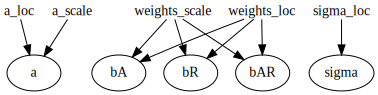

In [32]:
pyro.render_model(custom_guide, model_args=(is_cont_africa, ruggedness, log_gdp), render_params=True)

**Example: Bayesian regression via stochastic variational inference (SVI)**

In [39]:
auto_guide = pyro.infer.autoguide.AutoNormal(model)

In [35]:
adam = pyro.optim.Adam({"lr": 0.02})
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

CPU times: user 6.26 s, sys: 101 ms, total: 6.36 s
Wall time: 6.97 s


Text(0, 0.5, 'ELBO loss')

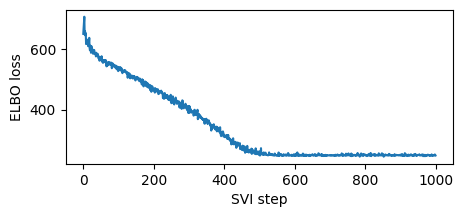

In [40]:
%%time
pyro.clear_param_store()

# These should be reset each training loop.
auto_guide = pyro.infer.autoguide.AutoNormal(model)
adam = pyro.optim.Adam({"lr": 0.02})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

losses = []
for step in range(1000 if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step(is_cont_africa, ruggedness, log_gdp)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [41]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

AutoNormal.locs.a 9.182589
AutoNormal.scales.a 0.067066364
AutoNormal.locs.bA -1.8571169
AutoNormal.scales.bA 0.13898468
AutoNormal.locs.bR -0.18209091
AutoNormal.scales.bR 0.040969223
AutoNormal.locs.bAR 0.3135896
AutoNormal.scales.bAR 0.08325768
AutoNormal.locs.sigma -2.2356844
AutoNormal.scales.sigma 0.06527055


In [42]:
with pyro.plate("samples", 800, dim=-1):
    samples = auto_guide(is_cont_africa, ruggedness)

gamma_within_africa = samples["bR"] + samples["bAR"]
gamma_outside_africa = samples["bR"]

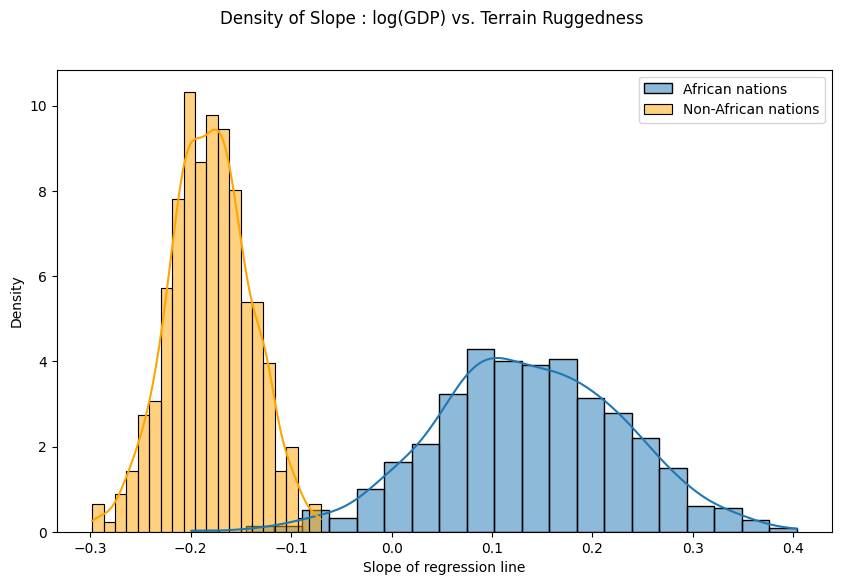

In [43]:
fig = plt.figure(figsize=(10, 6))
sns.histplot(gamma_within_africa.detach().cpu().numpy(), kde=True, stat="density", label="African nations")
sns.histplot(gamma_outside_africa.detach().cpu().numpy(), kde=True, stat="density", label="Non-African nations", color="orange")
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");
plt.xlabel("Slope of regression line")
plt.legend()
plt.show()


***Model Evaluation in Pyro***


**Example: posterior predictive uncertainty in Pyro**

In [45]:
predictive = pyro.infer.Predictive(model, guide=auto_guide, num_samples=800)
svi_samples = predictive(is_cont_africa, ruggedness, log_gdp=None)
svi_gdp = svi_samples["obs"]

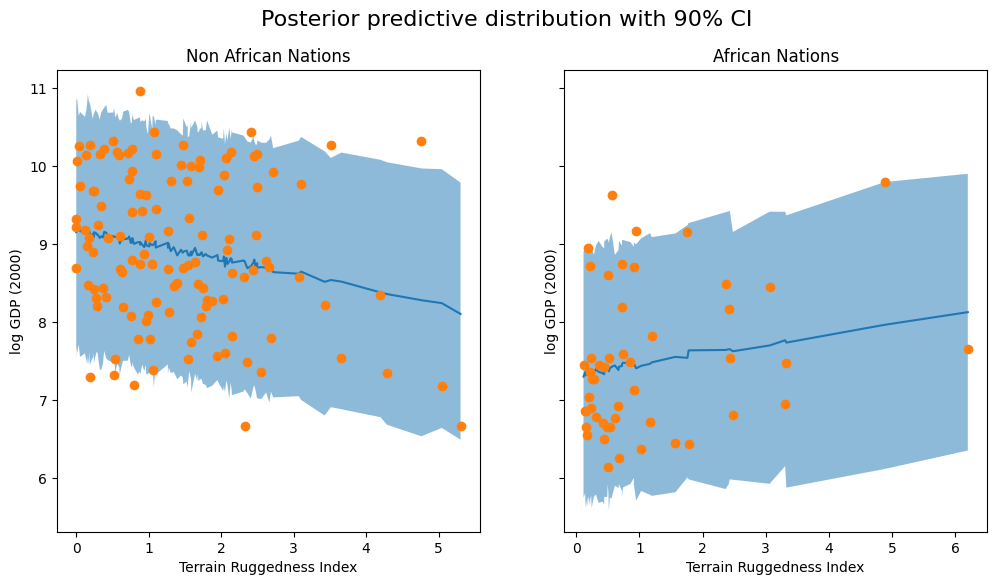

In [46]:
predictions = pd.DataFrame({
    "cont_africa": is_cont_africa,
    "rugged": ruggedness,
    "y_mean": svi_gdp.mean(0).detach().cpu().numpy(),
    "y_perc_5": svi_gdp.kthvalue(int(len(svi_gdp) * 0.05), dim=0)[0].detach().cpu().numpy(),
    "y_perc_95": svi_gdp.kthvalue(int(len(svi_gdp) * 0.95), dim=0)[0].detach().cpu().numpy(),
    "true_gdp": log_gdp,
})
african_nations = predictions[predictions["cont_africa"] == 1].sort_values(by=["rugged"])
non_african_nations = predictions[predictions["cont_africa"] == 0].sort_values(by=["rugged"])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)

ax[0].plot(non_african_nations["rugged"], non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"], non_african_nations["y_perc_5"], non_african_nations["y_perc_95"], alpha=0.5)
ax[0].plot(non_african_nations["rugged"], non_african_nations["true_gdp"], "o")
ax[0].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="Non African Nations")

ax[1].plot(african_nations["rugged"], african_nations["y_mean"])
ax[1].fill_between(african_nations["rugged"], african_nations["y_perc_5"], african_nations["y_perc_95"], alpha=0.5)
ax[1].plot(african_nations["rugged"], african_nations["true_gdp"], "o")
ax[1].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="African Nations");

In [47]:
mvn_guide = pyro.infer.autoguide.AutoMultivariateNormal(model)

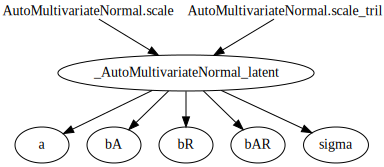

In [49]:
pyro.render_model(mvn_guide, model_args=(is_cont_africa, ruggedness, log_gdp), render_params=True)

CPU times: user 5.17 s, sys: 206 ms, total: 5.37 s
Wall time: 6.7 s


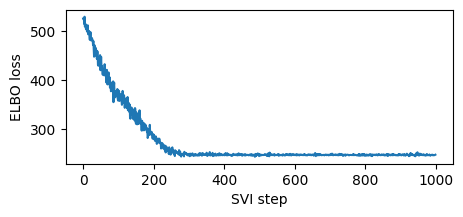

In [50]:
%%time
pyro.clear_param_store()
mvn_guide = pyro.infer.autoguide.AutoMultivariateNormal(model)
svi = pyro.infer.SVI(model,
                     mvn_guide,
                     pyro.optim.Adam({"lr": 0.02}),
                     pyro.infer.Trace_ELBO())

losses = []
for step in range(1000 if not smoke_test else 2):
    loss = svi.step(is_cont_africa, ruggedness, log_gdp)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

with pyro.plate("samples", 800, dim=-1):
    mvn_samples = mvn_guide(is_cont_africa, ruggedness)

mvn_gamma_within_africa = mvn_samples["bR"] + mvn_samples["bAR"]
mvn_gamma_outside_africa = mvn_samples["bR"]

# Interface note: reuse guide samples for prediction by passing them to Predictive
# via the posterior_samples keyword argument instead of passing the guide as above
assert "obs" not in mvn_samples
mvn_predictive = pyro.infer.Predictive(model, posterior_samples=mvn_samples)
mvn_predictive_samples = mvn_predictive(is_cont_africa, ruggedness, log_gdp=None)

mvn_gdp = mvn_predictive_samples["obs"]

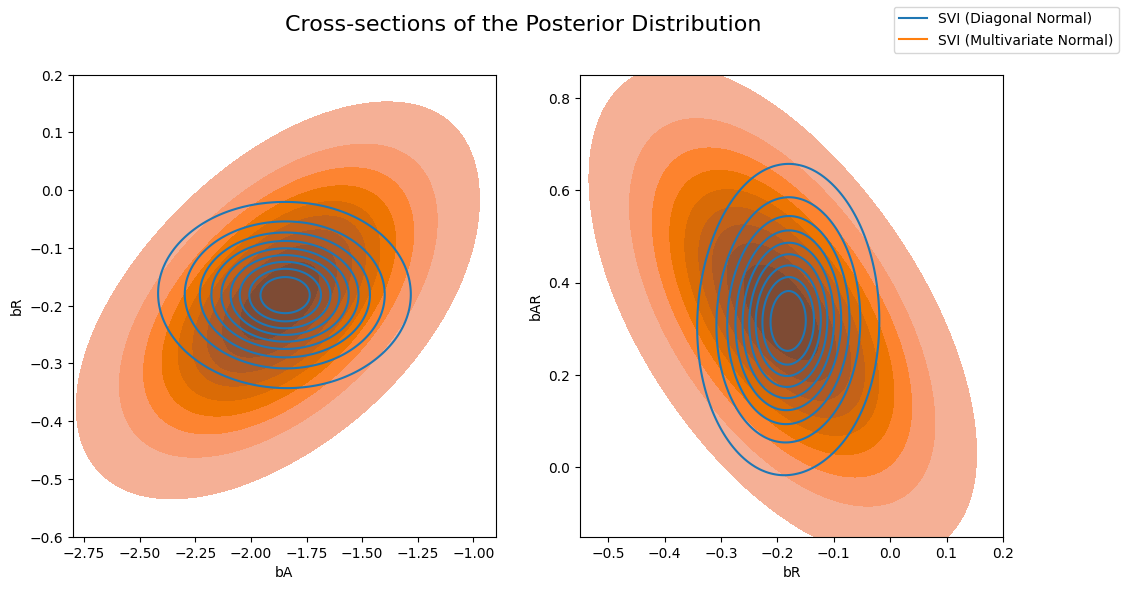

In [51]:
svi_samples = {k: v.detach().cpu().numpy() for k, v in samples.items()}
svi_mvn_samples = {k: v.detach().cpu().numpy() for k, v in mvn_samples.items()}

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-sections of the Posterior Distribution", fontsize=16)
sns.kdeplot(svi_samples["bA"], y=svi_samples["bR"], ax=axs[0], bw_adjust=4 )
sns.kdeplot(svi_mvn_samples["bA"], y=svi_mvn_samples["bR"], ax=axs[0], shade=True, bw_adjust=4)
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.8, -0.9), ylim=(-0.6, 0.2))

sns.kdeplot(svi_samples["bR"], y=svi_samples["bAR"], ax=axs[1],bw_adjust=4 )
sns.kdeplot(svi_mvn_samples["bR"], y=svi_mvn_samples["bAR"], ax=axs[1], shade=True, bw_adjust=4)
axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.55, 0.2), ylim=(-0.15, 0.85))


for label, color in zip(["SVI (Diagonal Normal)", "SVI (Multivariate Normal)"], sns.color_palette()[:2]):
    plt.plot([], [],
                label=label, color=color)

fig.legend(loc='upper right')

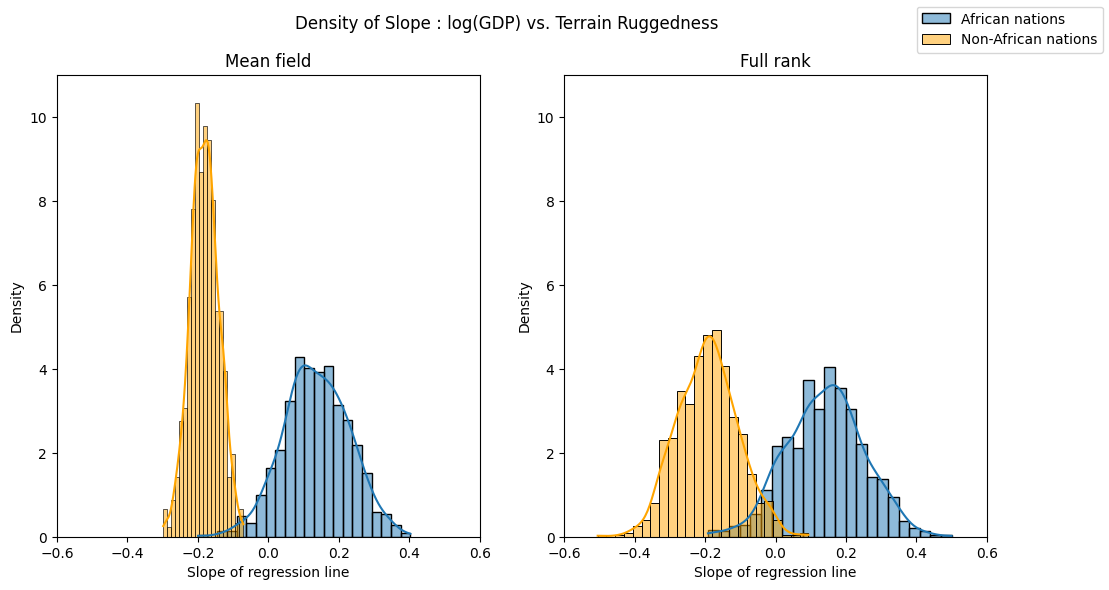

In [52]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");

sns.histplot(gamma_within_africa.detach().cpu().numpy(), ax=axs[0], kde=True, stat="density", label="African nations")
sns.histplot(gamma_outside_africa.detach().cpu().numpy(), ax=axs[0], kde=True, stat="density", color="orange", label="Non-African nations")
axs[0].set(title="Mean field", xlabel="Slope of regression line", xlim=(-0.6, 0.6), ylim=(0, 11))

sns.histplot(mvn_gamma_within_africa.detach().cpu().numpy(), ax=axs[1], kde=True, stat="density", label="African nations")
sns.histplot(mvn_gamma_outside_africa.detach().cpu().numpy(), ax=axs[1], kde=True, stat="density", color="orange", label="Non-African nations")
axs[1].set(title="Full rank", xlabel="Slope of regression line", xlim=(-0.6, 0.6), ylim=(0, 11))

handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

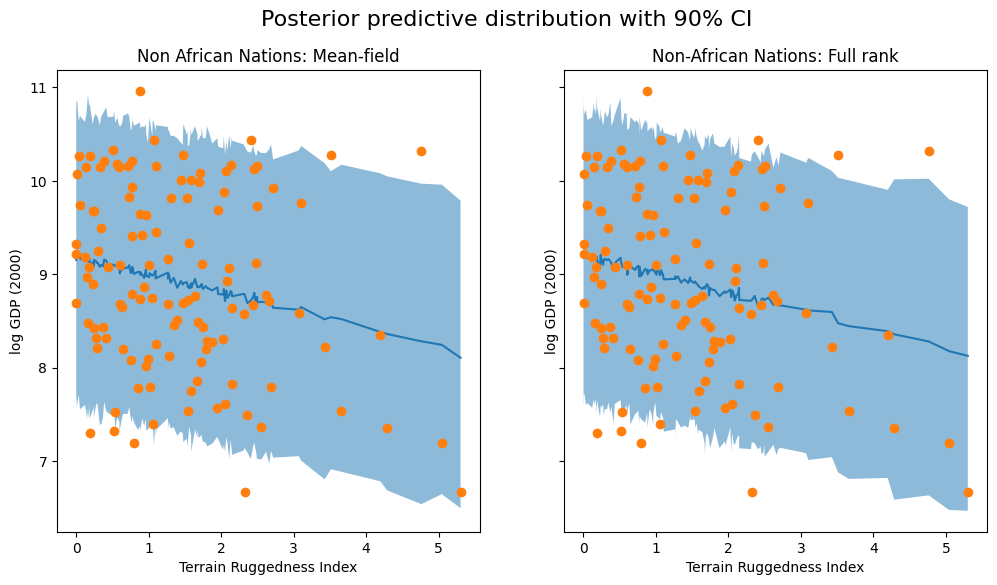

In [53]:
mvn_predictions = pd.DataFrame({
    "cont_africa": is_cont_africa,
    "rugged": ruggedness,
    "y_mean": mvn_gdp.mean(dim=0).detach().cpu().numpy(),
    "y_perc_5": mvn_gdp.kthvalue(int(len(mvn_gdp) * 0.05), dim=0)[0].detach().cpu().numpy(),
    "y_perc_95": mvn_gdp.kthvalue(int(len(mvn_gdp) * 0.95), dim=0)[0].detach().cpu().numpy(),
    "true_gdp": log_gdp,
})
mvn_non_african_nations = mvn_predictions[mvn_predictions["cont_africa"] == 0].sort_values(by=["rugged"])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)

ax[0].plot(non_african_nations["rugged"], non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"], non_african_nations["y_perc_5"], non_african_nations["y_perc_95"], alpha=0.5)
ax[0].plot(non_african_nations["rugged"], non_african_nations["true_gdp"], "o")
ax[0].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="Non African Nations: Mean-field")

ax[1].plot(mvn_non_african_nations["rugged"], mvn_non_african_nations["y_mean"])
ax[1].fill_between(mvn_non_african_nations["rugged"], mvn_non_african_nations["y_perc_5"], mvn_non_african_nations["y_perc_95"], alpha=0.5)
ax[1].plot(mvn_non_african_nations["rugged"], mvn_non_african_nations["true_gdp"], "o")
ax[1].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="Non-African Nations: Full rank");

In [54]:
import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.contrib.examples.bart import load_bart_od
from pyro.contrib.forecast import ForecastingModel, Forecaster, backtest, eval_crps
from pyro.infer.reparam import LocScaleReparam, StableReparam
from pyro.ops.tensor_utils import periodic_cumsum, periodic_repeat, periodic_features
from pyro.ops.stats import quantile
import matplotlib.pyplot as plt

%matplotlib inline
assert pyro.__version__.startswith('1.8.1')
pyro.set_rng_seed(20200221)

In [55]:
dataset = load_bart_od()
print(dataset.keys())
print(dataset["counts"].shape)
print(" ".join(dataset["stations"]))

dict_keys(['stations', 'start_date', 'counts'])
torch.Size([78888, 50, 50])
12TH 16TH 19TH 24TH ANTC ASHB BALB BAYF BERY CAST CIVC COLM COLS CONC DALY DBRK DELN DUBL EMBR FRMT FTVL GLEN HAYW LAFY LAKE MCAR MLBR MLPT MONT NBRK NCON OAKL ORIN PCTR PHIL PITT PLZA POWL RICH ROCK SANL SBRN SFIA SHAY SSAN UCTY WARM WCRK WDUB WOAK


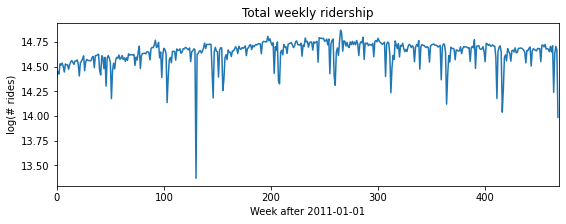

In [58]:
T, O, D = dataset["counts"].shape
data = dataset["counts"][:T // (24 * 7) * 24 * 7].reshape(T // (24 * 7), -1).sum(-1).log()
data = data.unsqueeze(-1)
plt.figure(figsize=(9, 3))
plt.plot(data)
plt.title("Total weekly ridership")
plt.ylabel("log(# rides)")
plt.xlabel("Week after 2011-01-01")
plt.xlim(0, len(data));

In [59]:
# First we need some boilerplate to create a class and define a .model() method.
class Model1(ForecastingModel):
    # We then implement the .model() method. Since this is a generative model, it shouldn't
    # look at data; however it is convenient to see the shape of data we're supposed to
    # generate, so this inputs a zeros_like(data) tensor instead of the actual data.
    def model(self, zero_data, covariates):
        data_dim = zero_data.size(-1)  # Should be 1 in this univariate tutorial.
        feature_dim = covariates.size(-1)

        # The first part of the model is a probabilistic program to create a prediction.
        # We use the zero_data as a template for the shape of the prediction.
        bias = pyro.sample("bias", dist.Normal(0, 10).expand([data_dim]).to_event(1))
        weight = pyro.sample("weight", dist.Normal(0, 0.1).expand([feature_dim]).to_event(1))
        prediction = bias + (weight * covariates).sum(-1, keepdim=True)
        # The prediction should have the same shape as zero_data (duration, obs_dim),
        # but may have additional sample dimensions on the left.
        assert prediction.shape[-2:] == zero_data.shape

        # The next part of the model creates a likelihood or noise distribution.
        # Again we'll be Bayesian and write this as a probabilistic program with
        # priors over parameters.
        noise_scale = pyro.sample("noise_scale", dist.LogNormal(-5, 5).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, noise_scale)

        # The final step is to call the .predict() method.
        self.predict(noise_dist, prediction)

In [60]:
T0 = 0              # begining
T2 = data.size(-2)  # end
T1 = T2 - 52        # train/test split

In [61]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
time = torch.arange(float(T2)) / 365
covariates = torch.stack([time], dim=-1)
forecaster = Forecaster(Model1(), data[:T1], covariates[:T1], learning_rate=0.1)

INFO 	 step    0 loss = 484401
INFO 	 step  100 loss = 0.609515
INFO 	 step  200 loss = -0.574004
INFO 	 step  300 loss = -0.592534
INFO 	 step  400 loss = -0.605461
INFO 	 step  500 loss = -0.597935
INFO 	 step  600 loss = -0.605653
INFO 	 step  700 loss = -0.612012
INFO 	 step  800 loss = -0.609876
INFO 	 step  900 loss = -0.613109
INFO 	 step 1000 loss = -0.606249


CPU times: user 4.31 s, sys: 155 ms, total: 4.46 s
Wall time: 5.24 s


torch.Size([1000, 52, 1]) torch.Size([52])


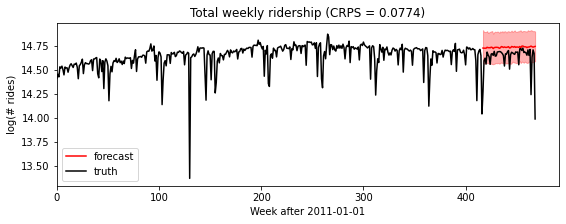

In [62]:
samples = forecaster(data[:T1], covariates, num_samples=1000)
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, data[T1:])
print(samples.shape, p10.shape)

plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(data, 'k-', label='truth')
plt.title("Total weekly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Week after 2011-01-01")
plt.xlim(0, None)
plt.legend(loc="best");

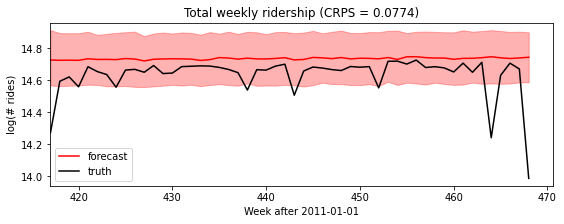

In [63]:
plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(torch.arange(T1, T2), data[T1:], 'k-', label='truth')
plt.title("Total weekly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Week after 2011-01-01")
plt.xlim(T1, None)
plt.legend(loc="best");

In [64]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
time = torch.arange(float(T2)) / 365
covariates = torch.cat([time.unsqueeze(-1),
                        periodic_features(T2, 365.25 / 7)], dim=-1)
forecaster = Forecaster(Model1(), data[:T1], covariates[:T1], learning_rate=0.1)

INFO 	 step    0 loss = 53174.4
INFO 	 step  100 loss = 0.526435
INFO 	 step  200 loss = -0.0154417
INFO 	 step  300 loss = -0.28896
INFO 	 step  400 loss = -0.311957
INFO 	 step  500 loss = -0.457713
INFO 	 step  600 loss = -0.456495
INFO 	 step  700 loss = -0.548652
INFO 	 step  800 loss = -0.520295
INFO 	 step  900 loss = -0.568069
INFO 	 step 1000 loss = -0.594111


CPU times: user 4.63 s, sys: 64.9 ms, total: 4.69 s
Wall time: 5.03 s


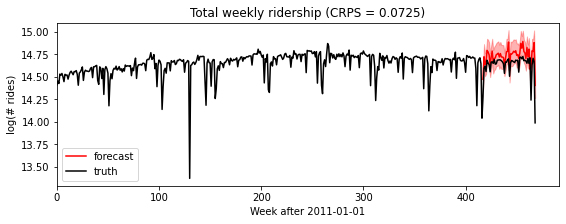

In [65]:
samples = forecaster(data[:T1], covariates, num_samples=1000)
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, data[T1:])

plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(data, 'k-', label='truth')
plt.title("Total weekly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Week after 2011-01-01")
plt.xlim(0, None)
plt.legend(loc="best");

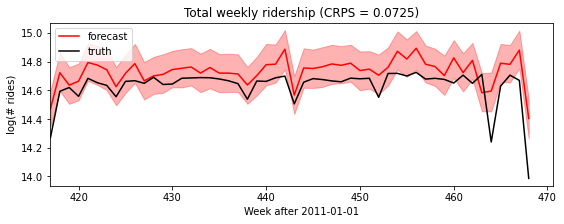

In [66]:
plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(torch.arange(T1, T2), data[T1:], 'k-', label='truth')
plt.title("Total weekly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Week after 2011-01-01")
plt.xlim(T1, None)
plt.legend(loc="best");

In [67]:
class Model2(ForecastingModel):
    def model(self, zero_data, covariates):
        data_dim = zero_data.size(-1)
        feature_dim = covariates.size(-1)
        bias = pyro.sample("bias", dist.Normal(0, 10).expand([data_dim]).to_event(1))
        weight = pyro.sample("weight", dist.Normal(0, 0.1).expand([feature_dim]).to_event(1))

        # We'll sample a time-global scale parameter outside the time plate,
        # then time-local iid noise inside the time plate.
        drift_scale = pyro.sample("drift_scale",
                                  dist.LogNormal(-20, 5).expand([1]).to_event(1))
        with self.time_plate:
            # We'll use a reparameterizer to improve variational fit. The model would still be
            # correct if you removed this context manager, but the fit appears to be worse.
            with poutine.reparam(config={"drift": LocScaleReparam()}):
                drift = pyro.sample("drift", dist.Normal(zero_data, drift_scale).to_event(1))

        # After we sample the iid "drift" noise we can combine it in any time-dependent way.
        # It is important to keep everything inside the plate independent and apply dependent
        # transforms outside the plate.
        motion = drift.cumsum(-2)  # A Brownian motion.

        # The prediction now includes three terms.
        prediction = motion + bias + (weight * covariates).sum(-1, keepdim=True)
        assert prediction.shape[-2:] == zero_data.shape

        # Construct the noise distribution and predict.
        noise_scale = pyro.sample("noise_scale", dist.LogNormal(-5, 5).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, noise_scale)
        self.predict(noise_dist, prediction)

In [68]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
time = torch.arange(float(T2)) / 365
covariates = periodic_features(T2, 365.25 / 7)
forecaster = Forecaster(Model2(), data[:T1], covariates[:T1], learning_rate=0.1,
                        time_reparam="dct",
                       )

/Users/liyanran/opt/anaconda3/envs/online/lib/python3.9/site-packages/pyro/poutine/reparam_messenger.py:111: RuntimeWarning: At pyro.sample('drift_decentered',...), HaarReparam does not commute with initialization; falling back to default initialization.
  warnings.warn(
INFO 	 step    0 loss = 1.73259e+09
INFO 	 step  100 loss = 1.09182
INFO 	 step  200 loss = -0.0402735
INFO 	 step  300 loss = -0.156852
INFO 	 step  400 loss = -0.243867
INFO 	 step  500 loss = -0.371154
INFO 	 step  600 loss = -0.334386
INFO 	 step  700 loss = -0.43255
INFO 	 step  800 loss = -0.450773
INFO 	 step  900 loss = -0.484612
INFO 	 step 1000 loss = -0.520161


CPU times: user 9.27 s, sys: 110 ms, total: 9.38 s
Wall time: 9.9 s


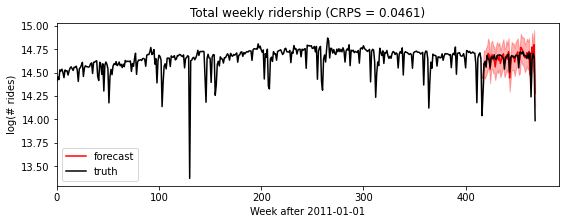

In [69]:
samples = forecaster(data[:T1], covariates, num_samples=1000)
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, data[T1:])

plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(data, 'k-', label='truth')
plt.title("Total weekly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Week after 2011-01-01")
plt.xlim(0, None)
plt.legend(loc="best");

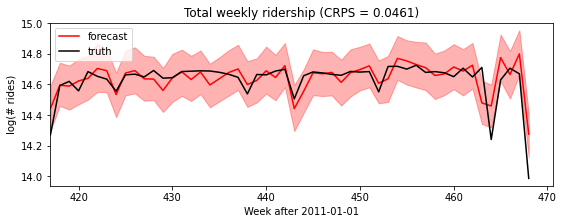

In [70]:
plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(torch.arange(T1, T2), data[T1:], 'k-', label='truth')
plt.title("Total weekly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Week after 2011-01-01")
plt.xlim(T1, None)
plt.legend(loc="best");

In [71]:
class Model3(ForecastingModel):
    def model(self, zero_data, covariates):
        data_dim = zero_data.size(-1)
        feature_dim = covariates.size(-1)
        bias = pyro.sample("bias", dist.Normal(0, 10).expand([data_dim]).to_event(1))
        weight = pyro.sample("weight", dist.Normal(0, 0.1).expand([feature_dim]).to_event(1))

        drift_scale = pyro.sample("drift_scale", dist.LogNormal(-20, 5).expand([1]).to_event(1))
        with self.time_plate:
            with poutine.reparam(config={"drift": LocScaleReparam()}):
                drift = pyro.sample("drift", dist.Normal(zero_data, drift_scale).to_event(1))
        motion = drift.cumsum(-2)  # A Brownian motion.

        prediction = motion + bias + (weight * covariates).sum(-1, keepdim=True)
        assert prediction.shape[-2:] == zero_data.shape

        # The next part of the model creates a likelihood or noise distribution.
        # Again we'll be Bayesian and write this as a probabilistic program with
        # priors over parameters.
        stability = pyro.sample("noise_stability", dist.Uniform(1, 2).expand([1]).to_event(1))
        skew = pyro.sample("noise_skew", dist.Uniform(-1, 1).expand([1]).to_event(1))
        scale = pyro.sample("noise_scale", dist.LogNormal(-5, 5).expand([1]).to_event(1))
        noise_dist = dist.Stable(stability, skew, scale)

        # We need to use a reparameterizer to handle the Stable distribution.
        # Note "residual" is the name of Pyro's internal sample site in self.predict().
        with poutine.reparam(config={"residual": StableReparam()}):
            self.predict(noise_dist, prediction)

In [72]:
%%time
pyro.set_rng_seed(2)
pyro.clear_param_store()
time = torch.arange(float(T2)) / 365
covariates = periodic_features(T2, 365.25 / 7)
forecaster = Forecaster(Model3(), data[:T1], covariates[:T1], learning_rate=0.1,
                        time_reparam="dct")
for name, value in forecaster.guide.median().items():
    if value.numel() == 1:
        print("{} = {:0.4g}".format(name, value.item()))

/Users/liyanran/opt/anaconda3/envs/online/lib/python3.9/site-packages/pyro/poutine/reparam_messenger.py:111: RuntimeWarning: At pyro.sample('drift_decentered',...), HaarReparam does not commute with initialization; falling back to default initialization.
  warnings.warn(
INFO 	 step    0 loss = 5.92061e+07
INFO 	 step  100 loss = 14.2542
INFO 	 step  200 loss = 3.83341
INFO 	 step  300 loss = 0.427218
INFO 	 step  400 loss = 0.0976613
INFO 	 step  500 loss = -0.150544
INFO 	 step  600 loss = -0.29219
INFO 	 step  700 loss = -0.383493
INFO 	 step  800 loss = -0.298209
INFO 	 step  900 loss = -0.35555
INFO 	 step 1000 loss = -0.390721


bias = 14.64
drift_scale = 2.814e-08
noise_stability = 1.937
noise_skew = 0.005204
noise_scale = 0.05988
CPU times: user 20 s, sys: 793 ms, total: 20.8 s
Wall time: 23.3 s


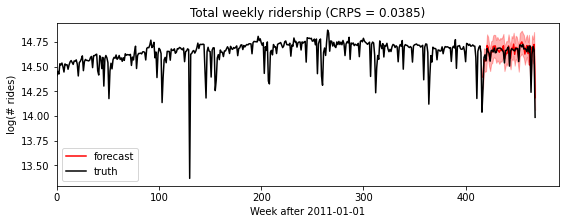

In [73]:
samples = forecaster(data[:T1], covariates, num_samples=1000)
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, data[T1:])

plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(data, 'k-', label='truth')
plt.title("Total weekly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Week after 2011-01-01")
plt.xlim(0, None)
plt.legend(loc="best");

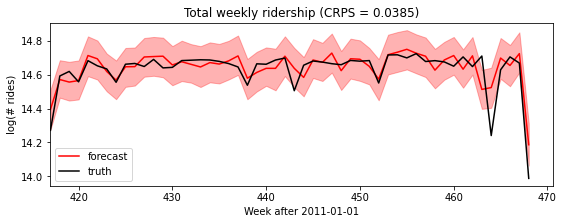

In [74]:
plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(torch.arange(T1, T2), data[T1:], 'k-', label='truth')
plt.title("Total weekly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Week after 2011-01-01")
plt.xlim(T1, None)
plt.legend(loc="best");

In [75]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
windows2 = backtest(data, covariates, Model2,
                    min_train_window=104, test_window=52, stride=26,
                    forecaster_options={"learning_rate": 0.1, "time_reparam": "dct",
                                        "log_every": 1000, "warm_start": True})

INFO 	 Training on window [0:104], testing on window [104:156]
/Users/liyanran/opt/anaconda3/envs/online/lib/python3.9/site-packages/pyro/poutine/reparam_messenger.py:111: RuntimeWarning: At pyro.sample('drift_decentered',...), HaarReparam does not commute with initialization; falling back to default initialization.
  warnings.warn(
INFO 	 step    0 loss = 3543.21
INFO 	 step 1000 loss = 0.120231
INFO 	 Training on window [0:130], testing on window [130:182]
INFO 	 step    0 loss = 0.244242
INFO 	 step 1000 loss = -0.177409
INFO 	 Training on window [0:156], testing on window [156:208]
INFO 	 step    0 loss = 0.588466
INFO 	 step 1000 loss = -0.0346216
INFO 	 Training on window [0:182], testing on window [182:234]
INFO 	 step    0 loss = 0.19907
INFO 	 step 1000 loss = -0.0999271
INFO 	 Training on window [0:208], testing on window [208:260]
INFO 	 step    0 loss = 0.148169
INFO 	 step 1000 loss = -0.201913
INFO 	 Training on window [0:234], testing on window [234:286]
INFO 	 step    0

CPU times: user 2min 5s, sys: 1.24 s, total: 2min 6s
Wall time: 2min 13s


In [76]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
windows3 = backtest(data, covariates, Model3,
                    min_train_window=104, test_window=52, stride=26,
                    forecaster_options={"learning_rate": 0.1, "time_reparam": "dct",
                                        "log_every": 1000, "warm_start": True})

INFO 	 Training on window [0:104], testing on window [104:156]
INFO 	 step    0 loss = 1852.88
INFO 	 step 1000 loss = 0.54006
INFO 	 Training on window [0:130], testing on window [130:182]
INFO 	 step    0 loss = 2.50826
INFO 	 step 1000 loss = 0.0551016
INFO 	 Training on window [0:156], testing on window [156:208]
INFO 	 step    0 loss = 2.64412
INFO 	 step 1000 loss = 0.0596583
INFO 	 Training on window [0:182], testing on window [182:234]
INFO 	 step    0 loss = 1.96395
INFO 	 step 1000 loss = -0.0187507
INFO 	 Training on window [0:208], testing on window [208:260]
INFO 	 step    0 loss = 1.57997
INFO 	 step 1000 loss = -0.146569
INFO 	 Training on window [0:234], testing on window [234:286]
INFO 	 step    0 loss = 1.30385
INFO 	 step 1000 loss = -0.114079
INFO 	 Training on window [0:260], testing on window [260:312]
INFO 	 step    0 loss = 1.22492
INFO 	 step 1000 loss = -0.220956
INFO 	 Training on window [0:286], testing on window [286:338]
INFO 	 step    0 loss = 0.992619
IN

CPU times: user 4min 1s, sys: 1.43 s, total: 4min 2s
Wall time: 4min 8s


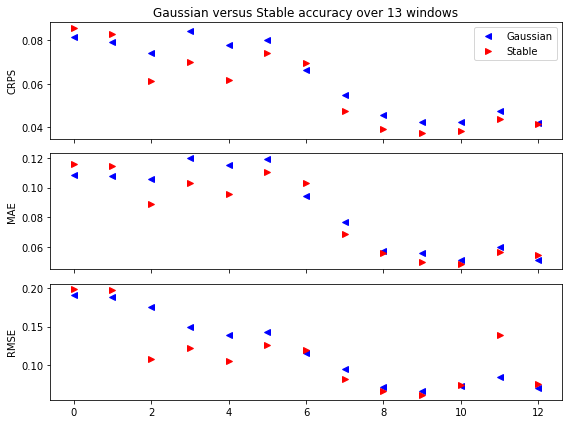

In [77]:
fig, axes = plt.subplots(3, figsize=(8, 6), sharex=True)
axes[0].set_title("Gaussian versus Stable accuracy over {} windows".format(len(windows2)))
axes[0].plot([w["crps"] for w in windows2], "b<", label="Gaussian")
axes[0].plot([w["crps"] for w in windows3], "r>", label="Stable")
axes[0].set_ylabel("CRPS")
axes[1].plot([w["mae"] for w in windows2], "b<", label="Gaussian")
axes[1].plot([w["mae"] for w in windows3], "r>", label="Stable")
axes[1].set_ylabel("MAE")
axes[2].plot([w["rmse"] for w in windows2], "b<", label="Gaussian")
axes[2].plot([w["rmse"] for w in windows3], "r>", label="Stable")
axes[2].set_ylabel("RMSE")
axes[0].legend(loc="best")
plt.tight_layout()